# Importing Modules

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Loading the data

In [39]:
obs_data = pd.read_csv("final_observed_data.csv")
model_data = pd.read_csv("model_data.csv")
red_data = pd.read_csv("red_data.csv")


In [40]:
#Photometric data
obs_wavelength = obs_data['wavelength']  # in nm
obs_freq = obs_data['frequency'] # in Hz
obs_flux = obs_data['flux'] # in CGS units
obs_eflux = obs_data['fluxer'] # in CGS units


#Model data
model_wav = model_data['wavelength'] # in nm
model_freq = model_data['frequency'] # in Hz
model_flux = model_data['flux']     # in CGS

#Reddening data
red_wavelength=red_data['wavelength']
red_magn= red_data['magn'] # in mag


In [41]:
#For plotting Y-axis values
vflux = []                                    # Flux*Freq array
for i in range(len(obs_flux)):
  vflux.append(obs_flux[i]*obs_freq[i])

vflux_model = []                              # Model_flux*model_freq array
for i in range(len(model_flux)):
  vflux_model.append(model_flux[i]*model_freq[i])


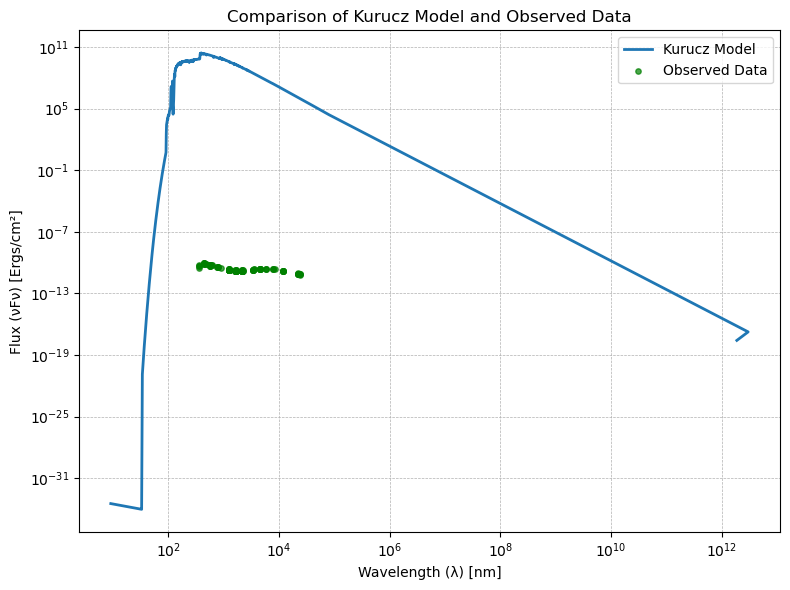

In [42]:
#Kurucz model plotted with observed data points
plt.figure(figsize=(8, 6))
plt.plot(model_wav, vflux_model, label="Kurucz Model", linewidth=2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Wavelength (λ) [nm]")
plt.ylabel("Flux (νFν) [Ergs/cm²]")
plt.scatter(obs_wavelength, vflux, s=15, label="Observed Data", color='green', alpha=0.7)
plt.legend()
plt.title("Comparison of Kurucz Model and Observed Data")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()



In [43]:
#Finding a wavelength that will match the wavlength closest to band wave in raw and model data
def wav_match(a, b):
    val = np.asarray(a)
    c = np.abs(val - b).argmin()

    i = np.where(val == val[c])[0][0]
    return i
H_wavelength = 1650
J_wavelength = 1250
K_wavelength = 2190

band_wave = H_wavelength              # band wavelength used for scaling the model

#Closest index that would match the photmetric data
data_index = wav_match(obs_wavelength, band_wave)

model_index  = wav_match(model_wav, band_wave)

In [44]:
print(data_index)
print(obs_wavelength[data_index])

print(model_index)
print(model_wav[model_index])

56
1649.477073
806
1645.0


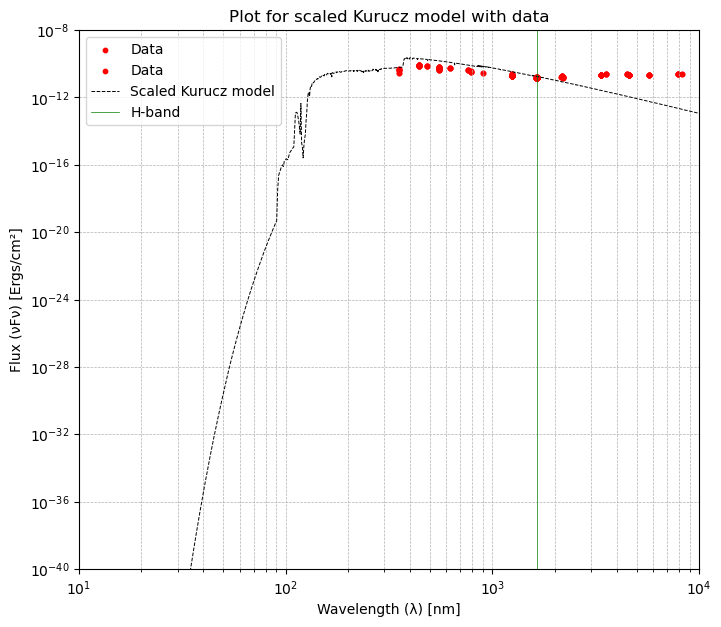

In [45]:
#Plot with scaled kurucz model and data
plt.figure(figsize = (8,7))
plt.scatter(obs_wavelength, vflux, s=10, label = "Data", color ='r')

scaling_coeff = vflux[data_index]/vflux_model[model_index]

vflux_model_scaled = []
for i in range(len(vflux_model)):
   vflux_model_scaled.append(vflux_model[i]*scaling_coeff)

plt.scatter(obs_wavelength, vflux, s=10, label="Data", color='r')
plt.plot(model_wav, vflux_model_scaled, 'k--', label="Scaled Kurucz model", linewidth=0.7)
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-40, 10**-8)
plt.xlim(10, 10**4)
plt.title("Plot for scaled Kurucz model with data")
plt.axvline(x=band_wave, color='g', label='H-band', linewidth=0.5)
plt.legend()
plt.xlabel("Wavelength (λ) [nm]")
plt.ylabel("Flux (νFν) [Ergs/cm²]")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)  
plt.show()

In [46]:
# Reddening values - array
red_values=[]
for n in range(len(obs_wavelength)):
  for m in range(len(red_wavelength)):
    if round(obs_wavelength[n])== float(red_wavelength[m]):
      red_values.append(red_magn[m])



In [100]:
#Effects of ism can be considered as negligible - at higher wavelengths
neglect= len(obs_flux) - len(red_values)
for i in range(neglect):
  red_values.append(0)
print(len(red_values))
red_flux=red_values

134


# Dereddening

In [107]:
#Dereddening
ebv = []            #colour excess index
ebv = np.arange(0,2,0.001)
N = len(obs_flux)   # Total no. of points
D = 1               # No. of parameters
#Corresponding flux values from model data
flux_mod = []
for i in range(len(obs_wavelength)):
  for j in range(len(model_wav)):
    if obs_wavelength[i]< model_wav[j]:
      flux_mod.append(model_flux[j-1])
      break




In [102]:
scaling_factor  =  obs_flux[data_index]/flux_mod[data_index]

scaling_flux = []

#For scaling the model
for i in range(len(flux_mod)):
     sf = scaling_factor*flux_mod[i]
     scaling_flux.append(sf)


# Chi^2 Minimisation and dereddening

In [61]:
a = []
chi_squared = []
def chi_square(a, b):
   chi = []
   for i in range (len(scaling_flux)):
     x = ((a[i]-scaling_flux[i])/(b[i]))**2
     chi.append(x)

   chi_sum = sum(chi)
   chi_sq = chi_sum*(1/(N-D))
   return chi_sq


In [ ]:
#Dereddening the non-infrared data

def red(i,flux,eflux):
  a = []
  b = []
  for j in range(len(red_flux)):
    if obs_wavelength[j] < band_wave:
     flux_dered = (10**(red_flux[j]*ebv[i]*0.4))*flux[j]               # Dereddened flux values
     eflux_dered = (10**(red_flux[j]*ebv[i]*0.4))*eflux[j]             # Dereddened error values on flux

     a.append(flux_dered)
     b.append(eflux_dered)
    else:                                                      # Infrared region is not dereddered
      a.append(flux[j])
      b.append(eflux[j])

  flux_dred.append(a)
  chi_sq = chi_square(a,b)
  return chi_sq


In [62]:
for i in range(len(ebv)):
  chi_sq = red(i, obs_flux, obs_eflux)
  chi_squared.append(chi_sq)

print(len(chi_squared))

1000


In [63]:
# To find the min. value of chi square
mini_chi = min(chi_squared)

for i in range(len(ebv)):
  if mini_chi == chi_squared[i]:
    ebv_best = ebv[i]
    index  = i

fdred_best = flux_dred[index]

print('Lowest chi^2 value is: ', mini_chi)
print('Color excess E(B-V) is: ', ebv_best)

Lowest chi^2 value is:  3491.9502129943203
Color excess E(B-V) is:  0.376


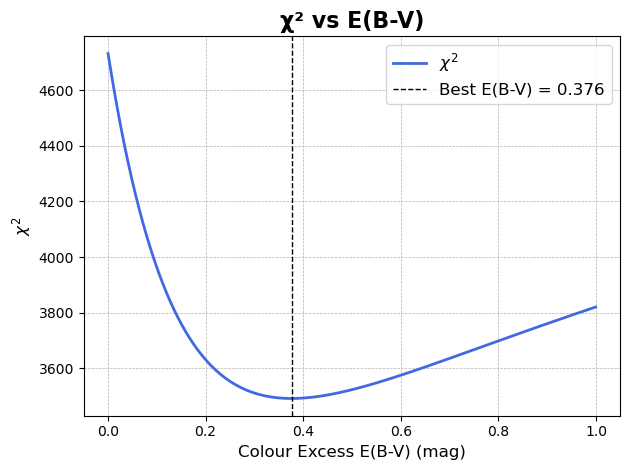

In [64]:
# Plot χ² vs E(B-V)
plt.title('χ² vs E(B-V)', fontsize=16, fontweight='bold')
plt.plot(ebv, chi_squared, color='royalblue', linewidth=2, label='$χ^2$')
plt.xlabel("Colour Excess E(B-V) (mag)", fontsize=12)
plt.ylabel("$χ^2$", fontsize=12)
plt.axvline(x=ebv_best, color='black', linestyle='--', label='Best E(B-V) = 0.376', linewidth=1)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


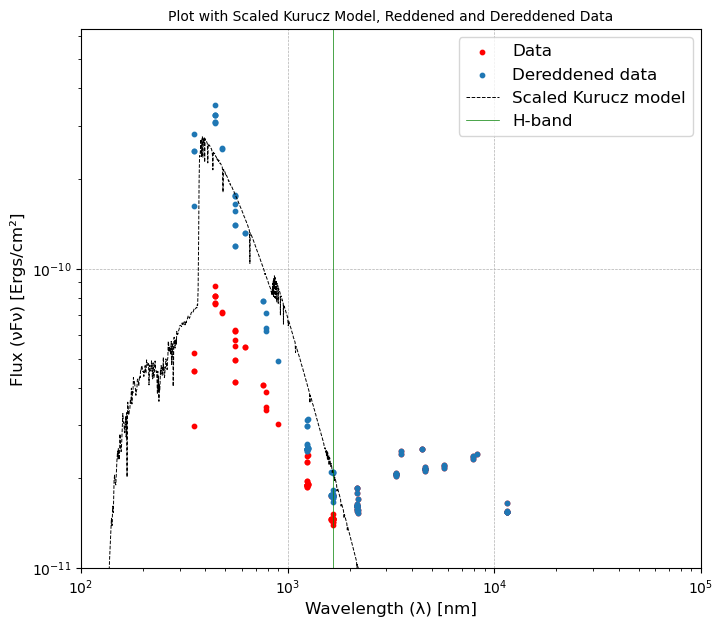

In [65]:
#Plot showing scaled Kurucz model with dereddened data
plt.figure(figsize = (8,7))
plt.scatter(obs_wavelength, vflux, s=10, label = "Data", color ='r')                  #Reddened data
plt.scatter(obs_wavelength, obs_freq*fdred_best, s=10, label = "Dereddened data")     #Dereddened data

#Scaling the model the dereddened flux
scaling_index = fdred_best[data_index]/flux_mod[data_index]

scaled_f = []
for i in range (len(model_flux)):
  scaled_f.append(scaling_index*model_flux[i]*model_freq[i])


plt.plot(model_wav, scaled_f, 'k--', label="Scaled Kurucz model", linewidth=0.7)
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-11, 10**-9.2)
plt.xlim(10**2, 10**5)
plt.title("Plot with Scaled Kurucz Model, Reddened and Dereddened Data", fontsize=10)
plt.axvline(x=band_wave, color='green', label='H-band', linewidth=0.5)
plt.legend(fontsize=12)
plt.xlabel("Wavelength (λ) [nm]", fontsize=12)
plt.ylabel("Flux (νFν) [Ergs/cm²]", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)

plt.show()

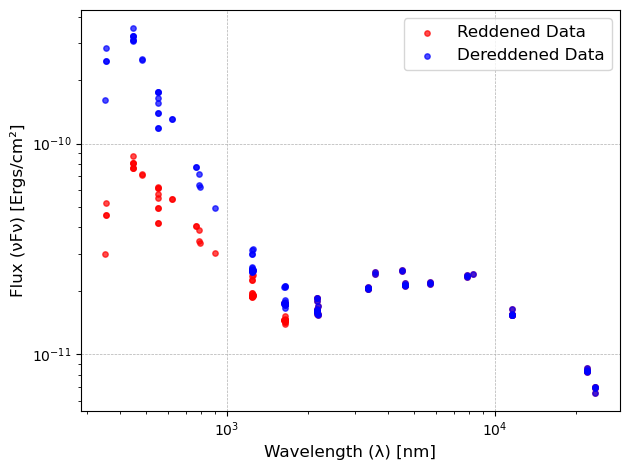

In [66]:
plt.scatter(obs_wavelength, vflux, s=15, label="Reddened Data", color='red', alpha=0.7)
plt.scatter(obs_wavelength, obs_freq*fdred_best, s=15, label="Dereddened Data", color='blue', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Wavelength (λ) [nm]", fontsize=12)
plt.ylabel("Flux (νFν) [Ergs/cm²]", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

# Monte Carlo Analysis

In [98]:
iteration = 100  # Iteration number
new_data = np.zeros(len(obs_flux))
old_data = obs_flux

chi_values = []
best_evb = []

for i in range(iteration):
    random_values = np.random.normal(size=len(obs_flux))  # Generate random numbers from normal distribution
    new_data = old_data + random_values * obs_eflux  # New_data = old_data + random * flux error

    h = np.arange(0, 1, 0.001)
    chis = []

    for o in range(len(h)):
        chi_sq = np.sum(((new_data - scaling_flux) / obs_eflux) ** 2)
        chis.append(chi_sq)

    min_chi = min(chis)

    best_evb_value = h[np.argmin(chis)]
    best_evb.append(best_evb_value)


The best E(B-V) value is: 0.37577
The error on E(B-V) is: 0.00172


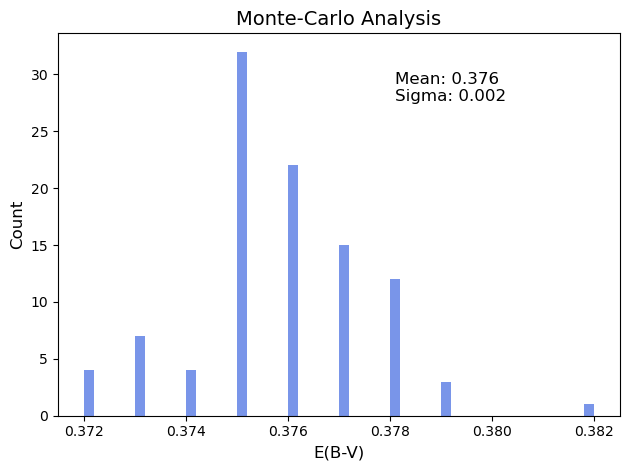

In [99]:
# Plotting to get best E(B-V)
plt.xlabel('E(B-V)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Monte-Carlo Analysis', fontsize=14)
count, bins, ignored = plt.hist(evb_best, 50, density=False, color='royalblue', alpha=0.7)
evb_mean = np.mean(evb_best)  # Mean
sigma = np.std(evb_best)      # Standard deviation
plt.text(0.6, 0.9, f"Mean: {evb_mean:.3f}\nSigma: {sigma:.3f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
print("The best E(B-V) value is:", evb_mean)
print("The error on E(B-V) is:", round(sigma, 5))
plt.tight_layout()
plt.show()


# Object Properties

In [80]:
solar_luminosity = 3.8515e33  # Solar luminosity [erg/s]
solar_radius = 6.9598e10  # Solar radius [cm]
stefan_boltzmann_const = 5.67051e-5  # Stefan-Boltzmann constant (σ) [erg/cm^2 s K^4]
effective_temp = 8250  # Effective temperature [K]
solar_flux = 1.4e6  # Solar flux [erg/s]


In [89]:
# distance_smc = 61.013e3  # Distance to SMC in parsecs
distance_smc_cm = 1.9e23  # Distance to SMC in centimeters

total_flux = abs(np.trapz(model_flux * scaling_index, x=model_freq))
luminosity_object = total_flux * 4 * np.pi * distance_smc_cm**2

luminosity_object_solar = luminosity_object / solar_luminosity

print("Luminosity of the object (in solar luminosities):", luminosity_object_solar)
print("Luminosity of the object (in ergs/s):", luminosity_object)


Luminosity of the object (in solar luminosities): 27404.599480012766
Luminosity of the object (in ergs/s): 1.0554881489726918e+38


In [90]:
stellar_radius = np.sqrt(luminosity_object / (4 * np.pi * stefan_boltzmann_const * (effective_temp**4)))
print("Radius of the star (in solar radius):", stellar_radius / solar_radius)


Radius of the star (in solar radius): 81.24675636711672


# Dust Properties

In [91]:

new_flux = [obs_flux[i] - (flux_mod[i] * scaling_index) for i in range(len(obs_wavelength)) if obs_wavelength[i] > band_wave]
new_freq = [obs_freq[i] for i in range(len(obs_wavelength)) if obs_wavelength[i] > band_wave]

total_flux_dust = abs(np.trapz(new_flux, x=new_freq))
luminosity_dust = total_flux_dust * 4 * np.pi * distance_smc_cm**2
luminosity_dust_solar = luminosity_dust / solar_luminosity

print(luminosity_dust_solar)


4720.928772150395


In [92]:
l_ratio = 1 - np.abs((luminosity_object - luminosity_dust) / luminosity_object)
print("Luminosity ratio:", l_ratio)


Luminosity ratio: 0.17226775292204333


In [105]:
flux_modified = []
wavelength_modified = []

for i in range(len(obs_wavelength)):
    if obs_wavelength[i] > band_wave:
        flux_modified.append(fdred_best[i] * obs_freq[i])
        wavelength_modified.append(obs_wavelength[i])

max_flux = max(flux_modified)
print(max_flux)

index_max_flux = flux_modified.index(max_flux)
lambda_max = wavelength_modified[index_max_flux]
print("Lambda_max:", lambda_max)

weins_constant = 2.92 * 10**-3  # Wein's constant [m.K]
temperature_dust = weins_constant / (lambda_max * 10**-9)
print("Temperature of the dust:", temperature_dust, 'K')


2.50215e-11
Lambda_max: 4493.02287
Temperature of the dust: 649.8965361375958 K


In [106]:
radius_dust = np.sqrt((luminosity_dust) / (4 * np.pi * stefan_boltzmann_const * (temperature_dust**4)))
print("Radius of the dust (in solar radius):", radius_dust / solar_radius)


Radius of the dust (in solar radius): 5434.098152971648
